# Sequences

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

**Here, our 1000 synthetic data will follow
the trigonometric `sin` function,
applied to 0.01 times the time step.
To make the problem a little more interesting,
we corrupt each sample with additive noise.**
From this sequence we extract training examples,
each consisting of features and a label.


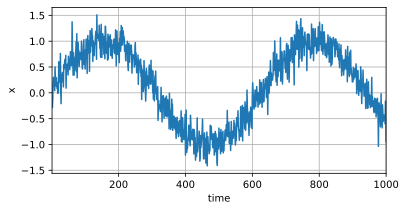

In [4]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as though
the data satisfied a **$\tau$-order Markov condition**,
and thus predicts $x_t$ using only the past $\tau$ observations.
**Thus for each time step we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**
This results in $1000-\tau$ examples,
since we lack sufficient history for $y_1, \ldots, y_\tau$.
While we could pad the first $\tau$ sequences with zeros,
to keep things simple, we drop them for now.
The resulting dataset contains $T - \tau$ examples,
where each input to the model has sequence length $\tau$.
We **create a data iterator on the first 600 examples**,
covering a period of the sin function.


In [5]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:] .reshape((-1, 1))

batch_size, n_train = 16, 600
# only the first n_train samples are used for traning
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

We use a MLP model with two fully connected layers.

In [11]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# squared loss does not contain 1/2
loss = nn.MSELoss()

## Training

In [13]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad() # reset gradient
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, ', f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1,  loss: 0.064937
epoch 2,  loss: 0.055232
epoch 3,  loss: 0.052221
epoch 4,  loss: 0.054592
epoch 5,  loss: 0.050153
epoch 6,  loss: 0.052747
epoch 7,  loss: 0.049711
epoch 8,  loss: 0.051707
epoch 9,  loss: 0.051443
epoch 10,  loss: 0.049008


## Prediction

**To evaluate our model, we first check
how well our model performs at one-step-ahead prediction**.


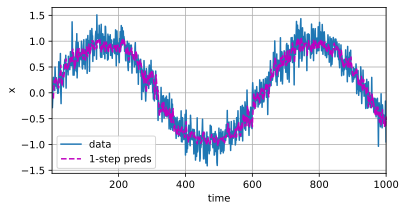

In [14]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

The one-step-ahead predictions look good,
even near the end $t=1000$.

Now consider, what if we only observed sequence data
up until time step 604 (`n_train + tau`)
but wished to make predictions several steps
into the future.
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


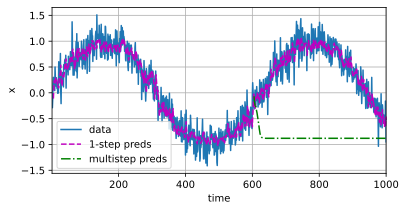

In [16]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))
    
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()], 
         'time',
         'x', 
         legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few prediction steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this owes to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.

Let's **take a closer look at the difficulties in $k$-step-ahead predictions**
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


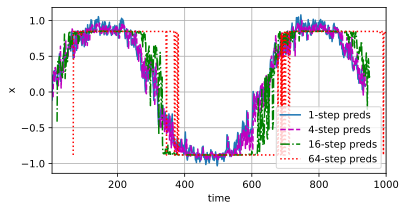

In [17]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# column i (i<tau) is from observations of x; its time is from i to i+T-tau-max_steps+1
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# column i (i>tau) is from the prediction at i-tau+1; its time is from i to i+T-tau-max_steps+1
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes
as we try to predict further into the future.
While the 4-step-ahead predictions still look good,
anything beyond that is almost useless.

## Summary

There is quite a difference in difficulty
between interpolation and extrapolation.
Consequently, if you have a sequence, always respect
the temporal order of the data when training,
i.e., never train on future data.
Given this kind of data,
sequence models require specialized statistical tools for estimation.
Two popular choices are autoregressive models
and latent-variable autoregressive models.
For causal models (e.g., time going forward),
estimating the forward direction is typically
a lot easier than the reverse direction.
For an observed sequence up to time step $t$,
its predicted output at time step $t+k$
is the $k$*-step-ahead prediction*.
As we predict further in time by increasing $k$,
the errors accumulate and the quality of the prediction degrades,
often dramatically.